In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro
from sklearn.model_selection import GridSearchCV
import gc
import itertools
from sklearn.utils import resample
import ast
import json
import re
import statsmodels.api as sm

import utils 
import model_train
from constants import *
import particle_swarm
from scipy.stats import ttest_rel, shapiro, wilcoxon

%load_ext autoreload
%autoreload 2

In [2]:
# Set your folder path
folder_path = '/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Experiment results/V2/V2_1_G_Mean/Tracking info/'

# Get all files (not directories) in the folder
all_files = [
    f for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store'
]

# Define a regex pattern to extract k, n_cluster, and model name
pattern = r'track_info_k(\d+)_ncluster(\d+)_([^.]+)\.csv'


In [3]:
Plots_folder = '/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Experiment results/V2/V2_1_G_Mean/Results'

<h1>Iterations Checking<h1>

k: 20, n_cluster: 50, ML model: DT


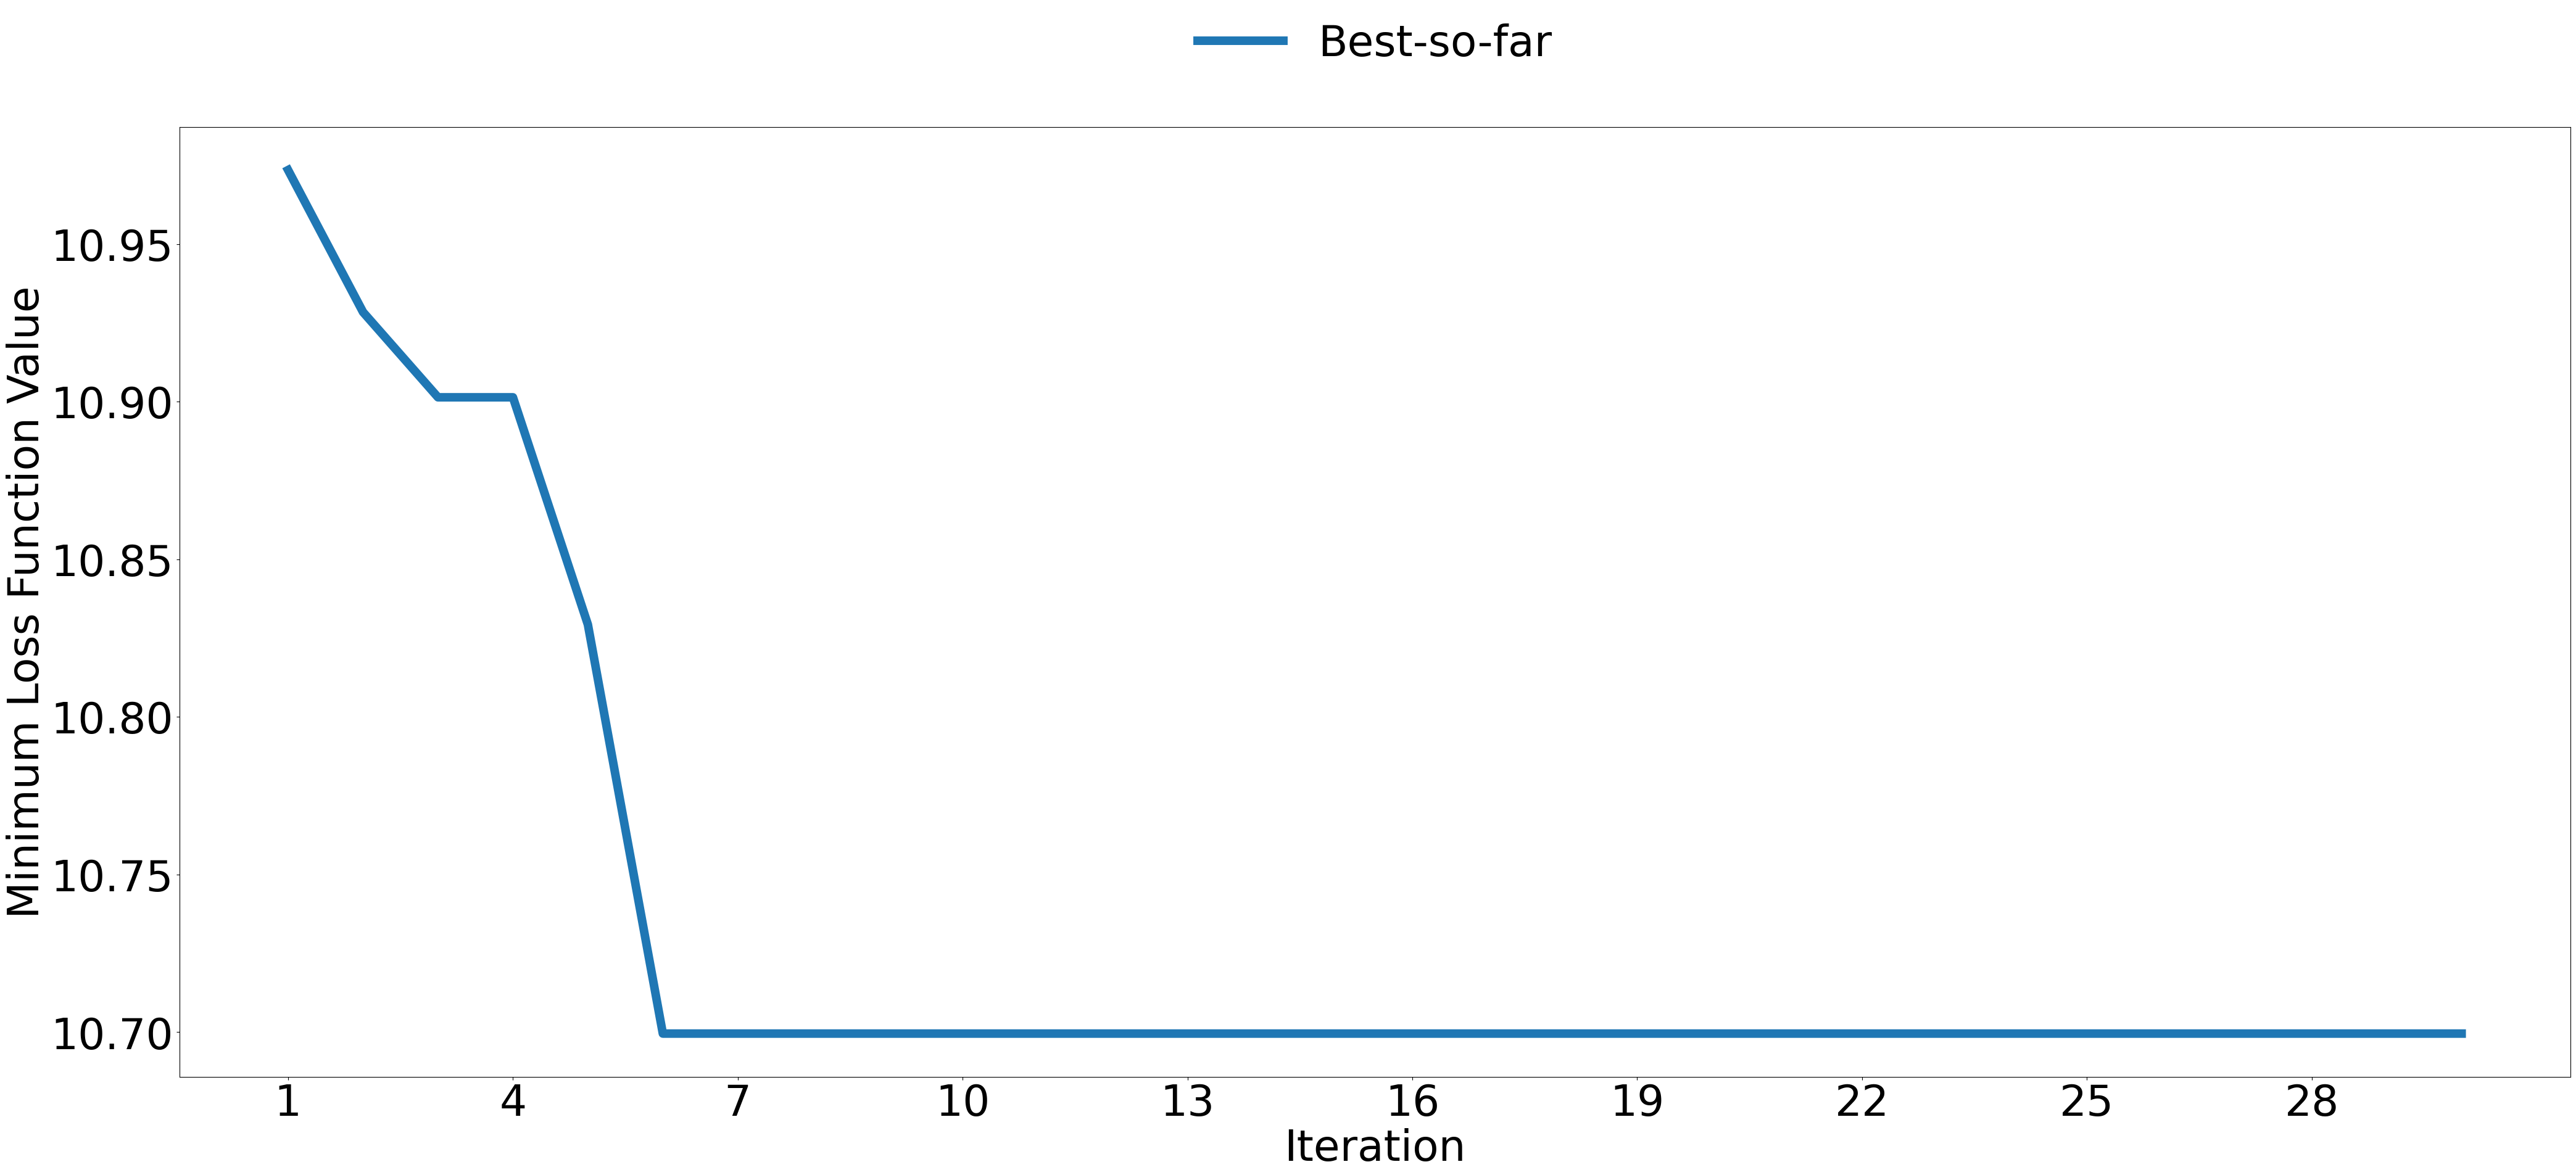

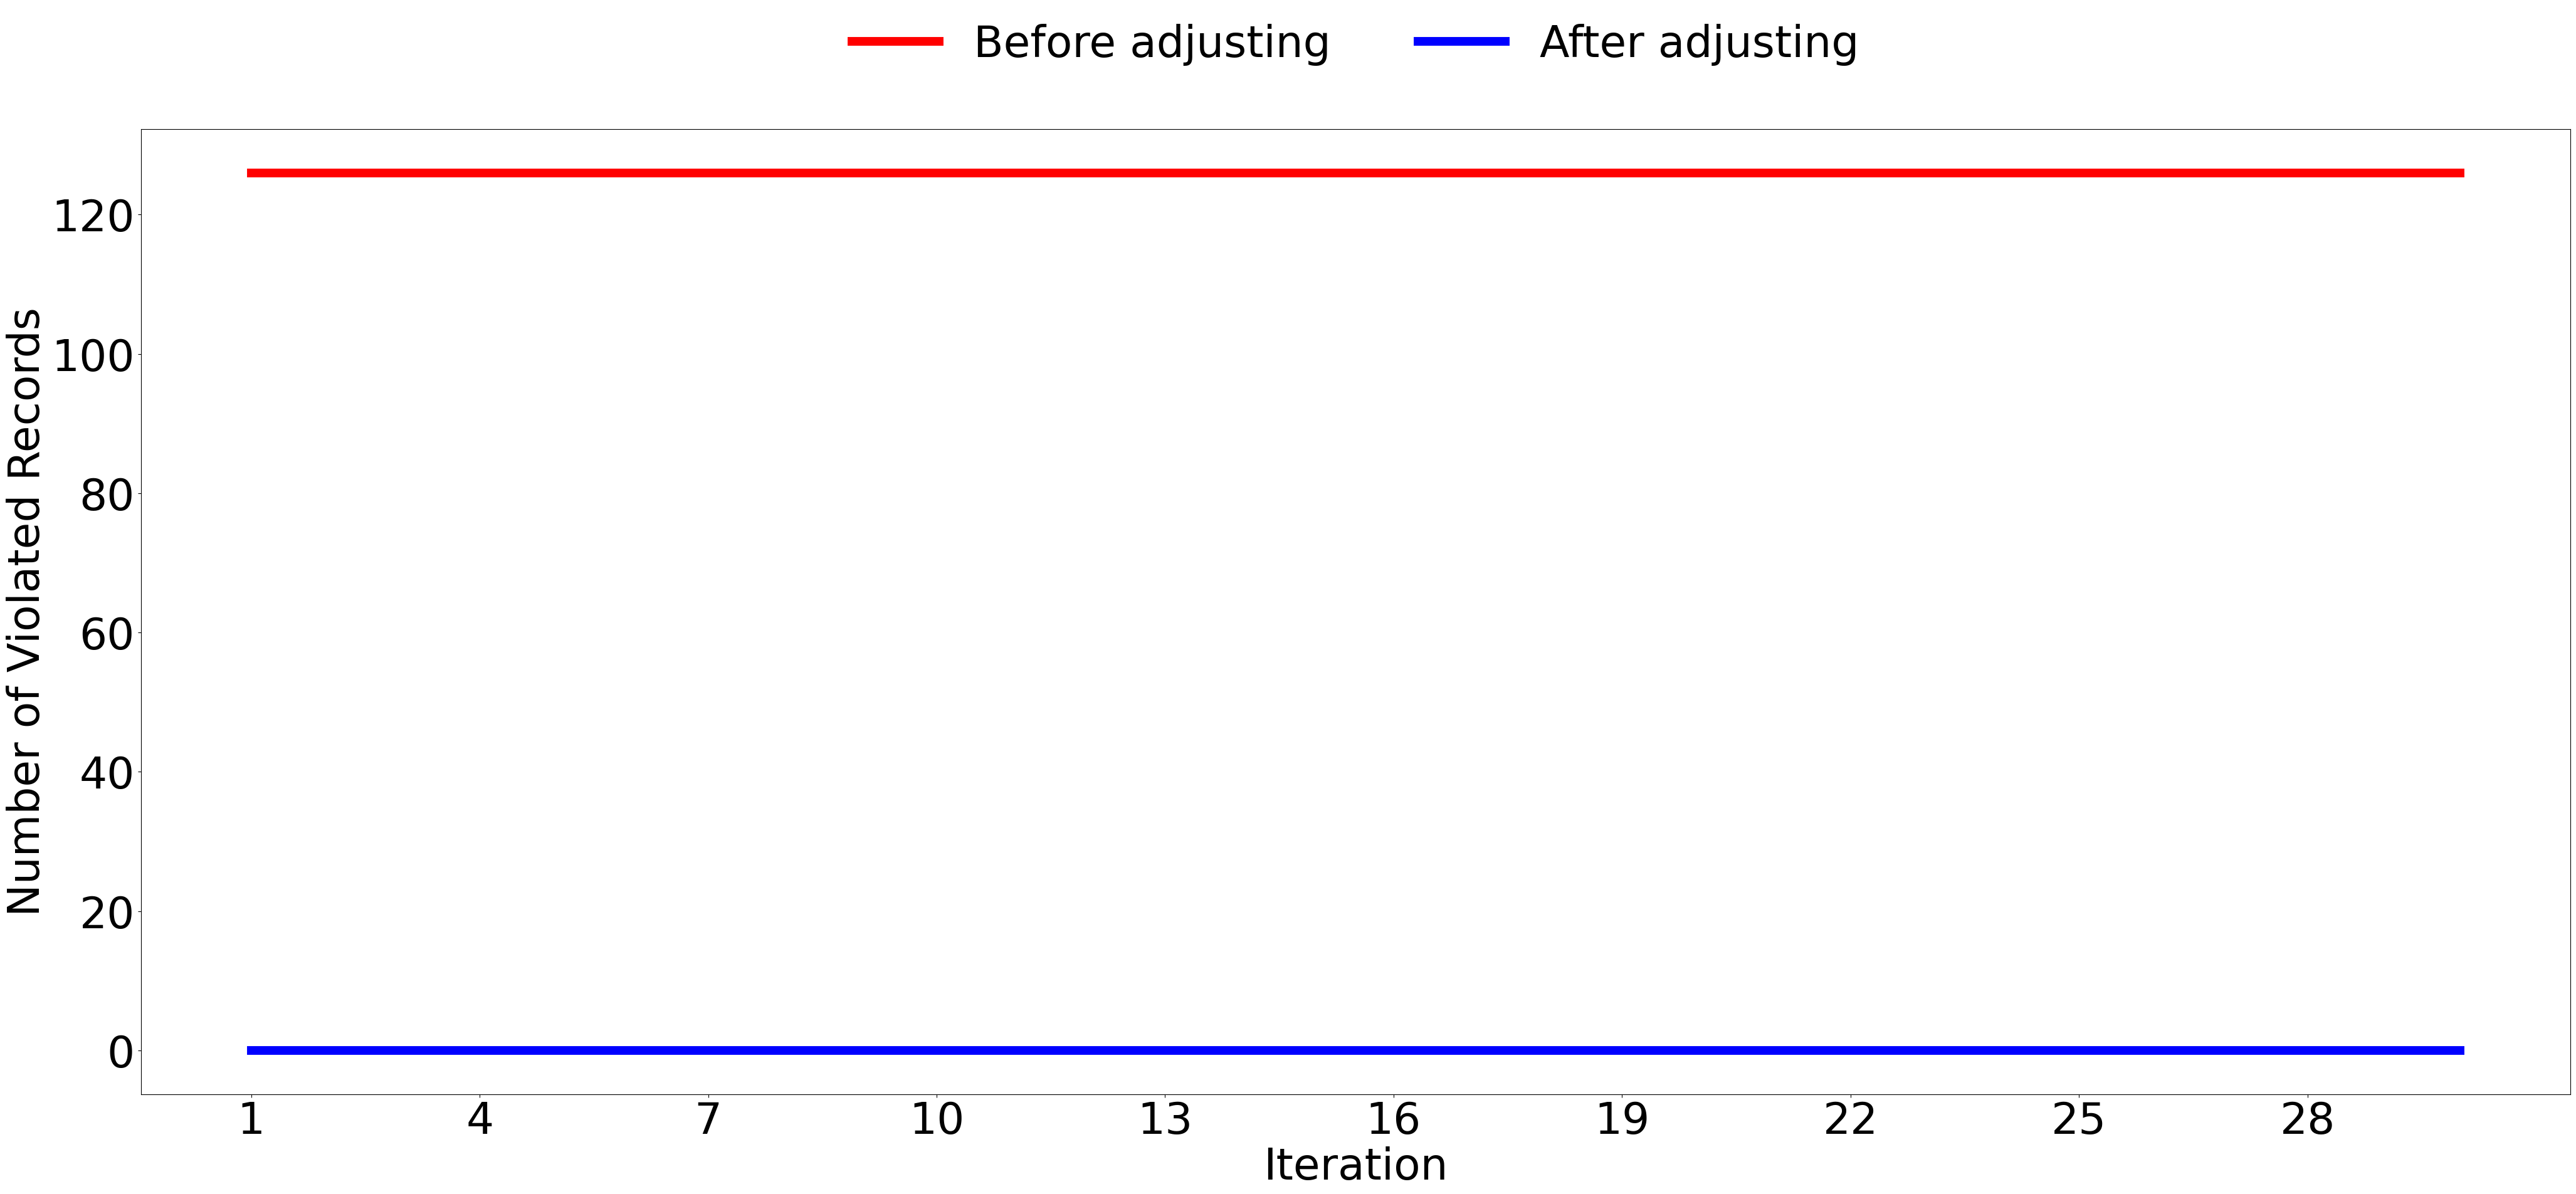

In [4]:
filedirectory = os.path.join(Plots_folder, 'Iterations results')
os.makedirs(filedirectory, exist_ok=True)  # Make sure the folder exists

for file in all_files:
    info = utils.extract_info_from_filename(file, pattern)
    print(f"k: {info['k']}, n_cluster: {info['n_cluster']}, ML model: {info['model']}")

    # Load the CSV file
    file_path = os.path.join(folder_path, file)
    results_df = pd.read_csv(file_path)

    # Create plot filenames
    base_filename = f"k{info['k']}_ncluster{info['n_cluster']}_{info['model']}"
    loss_plot_path = os.path.join(filedirectory, f"{base_filename}_global_best_max_loss_through_iterations.png")
    combined_plot_path = os.path.join(filedirectory, f"{base_filename}_violations_before_and_after_adjusting_through_iterations.png")

    # Save plots
    utils.plot_global_best_so_far(
        results_df, 'Entropy-Loss', 'Minimum Loss Function Value',
        agg_func='mean', y_range=None, output_path=loss_plot_path,show_plot=True
    )

    utils.plot_global_best_so_far_combined(
        results_df, 
        'total_num_violated_records_before_adjusting', 'Before adjusting',
        'total_num_violated_records_after_adjusting', 'After adjusting', 
        agg_func=None, y_range=None, 
        color_1='red', color_2='blue', output_path=combined_plot_path,show_plot=True
    )

<h1>Comparison Checking -- Maximum Loss<h1>

In [ ]:
metric_column = 'Entropy-Loss'

summary_df = utils.summarize_global_best_across_files(folder_path, pattern, metric_column)
print(summary_df)

In [ ]:
baseline_max_loss_dict = {
    'DT': 14.0570,
    'LR': 0.5762,
    'NB': 2.2771,
    'NN': 3.4248,
    'RF': 0.6991,
    'SVM': 0.6920
}

In [ ]:
filedirectory = os.path.join(Plots_folder, 'Compared to baseline')
os.makedirs(filedirectory, exist_ok=True)  # Make sure the folder exists

utils.plot_model_performance(summary_df, baseline_max_loss_dict, output_path=filedirectory,show_plot=True)

<h1>Comparison Checking -- Average Loss<h1>

In [5]:
baseline_avg_loss_dict = {
    'DT': 11.2059,
    'LR': 0.4975,
    'NB': 1.3150,
    'NN': 7.1022,
    'RF': 0.4919,
    'SVM': 0.6318
}

In [15]:
metric_column = 'Entropy-Loss'

summary_df = utils.summarize_global_best_across_files(folder_path, pattern, metric_column, agg_func='mean')
print(summary_df)

    k model  global_best  n_cluster
0  20    DT    10.699559         45


In [ ]:
utils.plot_model_performance(summary_df, baseline_avg_loss_dict, output_path=None,show_plot=True)

In [ ]:
baseline_df = pd.read_excel('/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Baseline experiment results/German_credit_baseline_ML_results.xlsm', sheet_name='German_credit_baseline_ML_resul')
baseline_df

In [ ]:
results_list = []

for file in all_files:
    info = utils.extract_info_from_filename(file, pattern)
    print(f"k: {info['k']}, n_cluster: {info['n_cluster']}, ML model: {info['model']}")

    # Load the CSV file
    file_path = os.path.join(folder_path, file)
    results_df = pd.read_csv(file_path)

    # Get global best loss values
    loss_values = utils.get_metric_values_of_global_best_particle(results_df, 'Entropy-Loss', agg_func='mean')
    mean_global_best = np.mean(loss_values)
    # Print results
    print(f"Mean Loss - Proposed moddel: {mean_global_best:.4f}")

    # Get baseline loss
    baseline_loss = np.array(baseline_df.loc[baseline_df['ML_Model'] == info['model'], 'Loss'])
    mean_baseline = np.mean(baseline_loss)
    print(f"Mean Loss - Baseline: {mean_baseline:.4f}")

    # Check normality
    differences = loss_values - baseline_loss
    stat, p = shapiro(differences)

    if p > 0.05:
        print("✅ Differences are normally distributed. Proceed with paired t-test.")
        t_stat, p_val = ttest_rel(loss_values, baseline_loss)
        # print(f"t-statistic: p-value: {p_val}")
        if p_val < 0.05:
            print("❌ Reject the null hypothesis: The means are significantly different.")
        else:
            print("✅ Fail to reject the null hypothesis: The means are not significantly different.")
    else:
        print("❌ Differences are NOT normally distributed. Use Wilcoxon signed-rank test.")
        t_stat, p_val = wilcoxon(loss_values, baseline_loss)
        # print(f"Wilcoxon-statistic: p-value: {p_val}")
        if p_val < 0.05:
            print("❌ Reject the null hypothesis: The means are significantly different.")
        else:
            print("✅ Fail to reject the null hypothesis: The means are not significantly different.")
    print("\n")

    # Save the results to a data frame
    results_list.append({
        'Model': info['model'],
        'k': info['k'],
        'n_cluster': info['n_cluster'],
        'Mean Loss - Proposed model': mean_global_best,
        'Mean Loss - Baseline': mean_baseline,
        'p-value': p_val
    })
    


In [ ]:
summary_stats_df = pd.DataFrame(results_list)

summary_stats_df.to_csv(os.path.join(Plots_folder, 'summary_stats.csv'), index=False)